In [ ]:
"""
Multi-asset PPO trading setup

Assumptions:
- prices: np.ndarray of shape (T, N_assets)
- features: np.ndarray of shape (T, F), already aligned with prices by time
- At each step t:
    * Agent observes state s_t = [features_t, position_pct, cash_pct]
    * Agent outputs a_t in [-1,1]^N_assets (one PPO output per asset)
    * We follow your mapping:
        E_t = cash_t + sum(p_i * S_i_t)
        For N assets, each asset gets E_t / N as base scale:
            V_i = (E_t / N) * a_i
            N_i_target = V_i / S_i_t
            Delta_i = N_i_target - p_i (trade size)
    * Reward is portfolio return from t to t+1 minus transaction costs
"""

import numpy as np
import gymnasium as gym
from gymnasium import spaces

import torch
import torch.nn as nn
from torch.distributions import Normal


# ==========================
# 1. Trading Environment (gymnasium style)
# ==========================

class MultiAssetTradingEnv(gym.Env):
    """
    FinRL-style multi-asset trading environment with continuous actions,
    following your order-size mapping diagram.

    State: [features_t, position_value_pct, cash_pct]
    Action: Box[-1,1] of size N_assets
    Reward: portfolio return from t to t+1 (after trades) minus transaction cost

    Gymnasium API:
        reset() -> obs, info
        step(action) -> obs, reward, terminated, truncated, info
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        prices: np.ndarray,
        features: np.ndarray,
        initial_cash: float = 100000.0,
        transaction_cost: float = 0.0005,  # 5 bps per dollar traded
        render_mode: str | None = None,
    ):
        super().__init__()

        assert prices.shape[0] == features.shape[0], \
            "prices and features must have the same time dimension"

        self.prices = prices.astype(np.float32)
        self.features = features.astype(np.float32)

        self.T, self.n_assets = self.prices.shape
        self.feature_dim = self.features.shape[1]

        self.initial_cash = float(initial_cash)
        self.transaction_cost = float(transaction_cost)
        self.render_mode = render_mode

        # Action: continuous allocation signals in [-1,1] for each asset
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self.n_assets,),
            dtype=np.float32,
        )

        # Observation: features + position percentage per asset + cash percentage
        self.obs_dim = self.feature_dim + self.n_assets + 1
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.obs_dim,),
            dtype=np.float32,
        )

        # Internal state
        self._reset_internal_state()

    # ---------- internal helpers ----------

    def _reset_internal_state(self):
        self.t = 0  # current time index
        self.positions = np.zeros(self.n_assets, dtype=np.float32)  # shares
        self.cash = float(self.initial_cash)
        self.equity = float(self.initial_cash)

    def _get_observation(self) -> np.ndarray:
        """
        Build observation vector at current time index self.t:
        [features_t, position_value_pct, cash_pct]
        """
        features_t = self.features[self.t]  # shape (F,)
        price_t = self.prices[self.t]       # shape (N_assets,)

        position_values = self.positions * price_t  # dollar value per asset
        total_equity = self.equity + 1e-8

        position_pct = position_values / total_equity  # shape (N_assets,)
        cash_pct = np.array([self.cash / total_equity], dtype=np.float32)

        obs = np.concatenate(
            [features_t, position_pct.astype(np.float32), cash_pct],
            axis=0
        )
        return obs.astype(np.float32)

    # ---------- gymnasium API ----------

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        """
        Gymnasium reset: returns (obs, info)
        """
        super().reset(seed=seed)
        self._reset_internal_state()
        obs = self._get_observation()
        info = {}
        return obs, info

    def step(self, action):
        """
        One trading step:
        - Use current prices S_t and action a_t to compute desired target positions,
          following your mapping:
            E_t = cash + sum(p_i * S_i_t)
            For general N assets:
                base_scale = E_t / N
                V_i = base_scale * a_i
                N_i_target = V_i / S_i_t
                Delta_i = N_i_target - p_i
        - Apply trades, charge transaction cost on traded notional
        - Move to next time t+1, compute portfolio return as reward
        """
        # Clip action into [-1,1]
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        price_t = self.prices[self.t]  # prices at time t
        price_tp1 = self.prices[self.t + 1] if self.t + 1 < self.T else price_t

        # 1. Compute current equity before trades
        current_position_value = np.sum(self.positions * price_t)
        self.equity = self.cash + current_position_value

        # 2. Mapping: compute target dollar exposure and shares
        base_scale = self.equity / float(self.n_assets)  # E / N
        target_values = base_scale * action  # V_i = E/N * a_i

        # Convert target dollar values to target positions (in shares)
        target_positions = np.where(
            price_t > 0,
            target_values / price_t,
            0.0,
        ).astype(np.float32)

        # Trade size (Delta_i)
        trade_shares = target_positions - self.positions  # + buy, - sell

        # 3. Apply trades, charge transaction cost
        trade_values = trade_shares * price_t  # signed trade notional per asset
        # total dollar turnover (absolute)
        dollar_turnover = np.sum(np.abs(trade_values))
        transaction_costs = self.transaction_cost * dollar_turnover

        # Update cash and positions:
        self.cash = self.cash - np.sum(trade_values) - transaction_costs
        self.positions = self.positions + trade_shares

        # 4. Move to t+1 and compute new portfolio value
        new_position_value = np.sum(self.positions * price_tp1)
        new_equity = self.cash + new_position_value

        # Reward: simple portfolio return from t to t+1
        reward = (new_equity - self.equity) / (self.equity + 1e-8)

        # Update equity and time
        self.equity = new_equity
        self.t += 1

        # Episode termination: reached last usable time index
        terminated = self.t >= self.T - 1
        truncated = False  # 可以加 max_steps 等逻辑，这里先不截断

        obs = self._get_observation()
        info = {
            "equity": self.equity,
            "cash": self.cash,
            "positions": self.positions.copy(),
        }

        # Gymnasium: (obs, reward, terminated, truncated, info)
        return obs, float(reward), terminated, truncated, info

    def render(self):
        print(
            f"t={self.t}, equity={self.equity:.2f}, cash={self.cash:.2f}, "
            f"positions={self.positions}"
        )


# ==========================
# 2. PPO Agent
# ==========================

class PolicyValueNet(nn.Module):
    """
    Shared base network with separate policy (mean) and value heads.
    Output distribution is Normal; actions are later clipped into [-1,1].
    """

    def __init__(self, obs_dim, action_dim, hidden_sizes=(128, 128)):
        super().__init__()
        layers = []
        input_dim = obs_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.base = nn.Sequential(*layers)

        self.mu_head = nn.Linear(input_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.value_head = nn.Linear(input_dim, 1)

    def forward(self, x):
        base = self.base(x)
        # keep mean in [-1,1] via tanh; we still use Normal and clip later
        mu = torch.tanh(self.mu_head(base))
        std = torch.exp(self.log_std)
        value = self.value_head(base).squeeze(-1)
        return mu, std, value

    def get_dist_and_value(self, obs):
        mu, std, value = self.forward(obs)
        dist = Normal(mu, std)
        return dist, value


class PPOAgent:
    def __init__(
        self,
        obs_dim,
        action_dim,
        lr=3e-4,
        gamma=0.99,
        lam=0.95,
        clip_ratio=0.2,
        vf_coef=0.5,
        ent_coef=0.0,
        max_grad_norm=0.5,
        device=None,
    ):
        self.device = device or (
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm

        self.net = PolicyValueNet(obs_dim, action_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def act(self, obs):
        """
        Given a single observation (numpy array), return action (numpy),
        log_prob, and value estimate.
        """
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        dist, value = self.net.get_dist_and_value(obs_t)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(-1)
        action_np = action.squeeze(0).cpu().numpy()
        log_prob_np = log_prob.item()
        value_np = value.item()
        return np.clip(action_np, -1.0, 1.0), log_prob_np, value_np

    def compute_gae(self, rewards, values, dones, last_value):
        """
        Generalized Advantage Estimation (GAE-Lambda)
        rewards, values, dones: numpy arrays length T
        last_value: scalar, V(s_{T})
        """
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_adv = 0.0
        for t in reversed(range(T)):
            mask = 1.0 - float(dones[t])
            delta = rewards[t] + self.gamma * last_value * mask - values[t]
            last_adv = delta + self.gamma * self.lam * mask * last_adv
            adv[t] = last_adv
            last_value = values[t]
        returns = values + adv
        return adv, returns

    def update(self, batch, epochs=10, batch_size=64):
        """
        batch: dict with keys
            'obs', 'actions', 'log_probs', 'returns', 'advantages'
        """
        obs = torch.as_tensor(batch["obs"], dtype=torch.float32, device=self.device)
        actions = torch.as_tensor(batch["actions"], dtype=torch.float32, device=self.device)
        old_log_probs = torch.as_tensor(batch["log_probs"], dtype=torch.float32, device=self.device)
        returns = torch.as_tensor(batch["returns"], dtype=torch.float32, device=self.device)
        advantages = torch.as_tensor(batch["advantages"], dtype=torch.float32, device=self.device)

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        n = obs.size(0)
        idxs = np.arange(n)

        for _ in range(epochs):
            np.random.shuffle(idxs)
            for start in range(0, n, batch_size):
                end = start + batch_size
                mb_idx = idxs[start:end]

                mb_obs = obs[mb_idx]
                mb_actions = actions[mb_idx]
                mb_old_log_probs = old_log_probs[mb_idx]
                mb_returns = returns[mb_idx]
                mb_advantages = advantages[mb_idx]

                dist, values = self.net.get_dist_and_value(mb_obs)
                new_log_probs = dist.log_prob(mb_actions).sum(-1)
                entropy = dist.entropy().sum(-1).mean()

                # Policy loss (clipped surrogate objective)
                ratio = torch.exp(new_log_probs - mb_old_log_probs)
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(
                    ratio,
                    1.0 - self.clip_ratio,
                    1.0 + self.clip_ratio
                ) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value loss
                value_loss = nn.functional.mse_loss(values, mb_returns)

                # Total loss
                loss = policy_loss + self.vf_coef * value_loss - self.ent_coef * entropy

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()


# ==========================
# 3. Minimal training loop (compatible with gymnasium)
# ==========================

def train_ppo_on_env(
    env: MultiAssetTradingEnv,
    agent: PPOAgent,
    total_steps: int = 50_000,
    rollout_horizon: int = 512,
):
    """
    Minimal PPO training loop.
    You can adapt this to log training curves, save models, etc.
    """
    obs, info = env.reset()
    step_count = 0

    while step_count < total_steps:
        # Collect one rollout
        obs_buf = []
        act_buf = []
        logp_buf = []
        rew_buf = []
        val_buf = []
        done_buf = []

        for _ in range(rollout_horizon):
            action, logp, value = agent.act(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated

            obs_buf.append(obs)
            act_buf.append(action)
            logp_buf.append(logp)
            rew_buf.append(reward)
            val_buf.append(value)
            done_buf.append(done)

            obs = next_obs
            step_count += 1

            if done:
                obs, info = env.reset()

            if step_count >= total_steps:
                break

        # Compute advantage & returns using last value estimate
        with torch.no_grad():
            last_value = agent.net.get_dist_and_value(
                torch.as_tensor(
                    obs, dtype=torch.float32, device=agent.device
                ).unsqueeze(0)
            )[1].item()

        obs_arr = np.array(obs_buf, dtype=np.float32)
        act_arr = np.array(act_buf, dtype=np.float32)
        logp_arr = np.array(logp_buf, dtype=np.float32)
        rew_arr = np.array(rew_buf, dtype=np.float32)
        val_arr = np.array(val_buf, dtype=np.float32)
        done_arr = np.array(done_buf, dtype=bool)

        adv, ret = agent.compute_gae(rew_arr, val_arr, done_arr, last_value)

        batch = {
            "obs": obs_arr,
            "actions": act_arr,
            "log_probs": logp_arr,
            "returns": ret,
            "advantages": adv,
        }

        agent.update(batch)

        print(f"Trained up to step {step_count}")

    print("Training finished.")




In [6]:
# ==========================
# Example usage with dummy data
# ==========================

if __name__ == "__main__":
    # Example: 5 ETFs, 1000 days, 20 signals per day
    T = 1000
    N_assets = 5
    F = 20

    # Dummy price paths (random walk)
    rng = np.random.default_rng(42)
    log_returns = rng.normal(0, 0.01, size=(T, N_assets))
    prices = 100 * np.exp(np.cumsum(log_returns, axis=0)).astype(np.float32)

    # Dummy features (here just some random numbers; in your project use real signals)
    features = rng.normal(size=(T, F)).astype(np.float32)

    env = MultiAssetTradingEnv(
        prices=prices,
        features=features,
        initial_cash=100000.0,
        transaction_cost=0.0005,
    )
    ppo_agent = PPOAgent(
        obs_dim=env.obs_dim,
        action_dim=env.n_assets,
        lr=3e-4,
        gamma=0.99,
        lam=0.95,
        clip_ratio=0.2,
    )

    train_ppo_on_env(env, ppo_agent, total_steps=5000, rollout_horizon=256)

Trained up to step 256
Trained up to step 512
Trained up to step 768
Trained up to step 1024
Trained up to step 1280
Trained up to step 1536
Trained up to step 1792
Trained up to step 2048
Trained up to step 2304
Trained up to step 2560
Trained up to step 2816
Trained up to step 3072
Trained up to step 3328
Trained up to step 3584
Trained up to step 3840
Trained up to step 4096
Trained up to step 4352
Trained up to step 4608
Trained up to step 4864
Trained up to step 5000
Training finished.


### Update the RL framework with new data and signal


Multi-asset PPO trading setup using team-provided minute data and signals.

Data sources (all already pushed by your teammates):

- `data.csv`  
  DateTime index at 1-minute frequency.  
  Columns like: `VOO_Close`, `VOO_Open`, `VOO_High`, `VOO_Low`, `VOO_Volume`, ...  
  for tickers: VOO, IEMG, GLDM, TLT, HYG.

- `volatility_forecasts.csv`  
  DateTime index (with timezone), columns: VOO, IEMG, GLDM, TLT, HYG.  
  Each is a 1-step ahead GARCH volatility forecast.

- `A6.csv`  
  DateTime index (with timezone), columns: VOO, IEMG, GLDM, TLT, HYG.  
  Alpha #6:
  
  $$
  \alpha^{(6)}_t = -\mathrm{corr}_{10}(\text{Open}, \text{Volume})
  $$

- `A101.csv`  
  DateTime index (with timezone), columns: VOO, IEMG, GLDM, TLT, HYG.  
  Alpha #101:
  
  $$
  \alpha^{(101)}_t =
  \frac{\text{Close}_t - \text{Open}_t}
       {(\text{High}_t - \text{Low}_t) + 0.001}
  $$

- `factor_outputs/`  
  Many files like `OHLC-open_lag_1_clean.csv`, `OHLC-high_lag_3_clean.csv`, ...  
  Each has columns: `[DateTime, ticker, <factor_name>]`.  
  These factors have already been shifted by 1 bar in `OHLC.py` to avoid look-ahead.

---

### Assumptions in this RL setup

**State at time \(t\)**  

$$
s_t = \big[\text{all signals at time } t,\ \text{position value percentages},\ \text{cash percentage}\big].
$$

**Action at time \(t\)**  

$$
a_t \in [-1, 1]^{N_{\text{assets}}}
$$

(one continuous signal per asset).

---

### Mapping from action to target position

Portfolio equity:

$$
E_t = \text{cash}_t + \sum_i p_i\, S_{i,t}
$$

where \(p_i\) is the number of units of asset \(i\) and \(S_{i,t}\) is its price at time \(t\).

Base scale per asset:

$$
\text{base\_scale} = \frac{E_t}{N_{\text{assets}}}
$$

Dollar value assigned to asset \(i\):

$$
V_i = \text{base\_scale} \cdot a_i
$$

Target number of units for asset \(i\):

$$
N^{\text{target}}_{i,t} = \frac{V_i}{S_{i,t}}
$$

Trade size (change in units):

$$
\Delta_i = N^{\text{target}}_{i,t} - p_i
$$

---

### Reward

Portfolio return from \(t\) to \(t+1\), net of transaction costs, based on minute-to-minute price changes:

$$
r_{t+1} 
= \frac{E_{t+1} - E_t}{E_t}
\;-\; \text{transaction\_costs}_{t}
$$


In [25]:
import os
import glob

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions import Normal


In [26]:


def build_price_and_features(
    data_path: str = "data.csv",
    vol_path: str = "volatility_forecasts.csv",
    a6_path: str = "A6.csv",
    a101_path: str = "A101.csv",
    factor_dir: str = "factor_outputs",
    tickers=("VOO", "IEMG", "GLDM", "TLT", "HYG"),
):
    """
    Build the price matrix (for reward calculation) and the feature matrix (state signals)
    from the team's minute-level data and signal CSVs.

    This function:
    - Reads prices from data.csv (OHLCV).
    - Reads vol / A6 / A101 from their CSVs.
    - Reads OHLC factors from factor_outputs/*_clean.csv.
    - Normalizes ALL timestamps to a common UTC-based naive timeline.
    - Aligns all signals to the same time index.
    - Handles NaN/Inf and drops warm-up periods.
    """

    # ---------- Helpers: normalize timestamps via UTC ----------
    def _normalize_index_utc_for_index(x):
        """
        For Index-like objects (e.g. df.index or an array of DateTime strings):
        parse as UTC, then drop timezone and return a DatetimeIndex.

        Examples:
        - '2025-08-04 09:30:00'        -> 09:30 UTC -> 09:30 (naive)
        - '2025-08-04 05:30:00-04:00'  -> 09:30 UTC -> 09:30 (naive)
        """
        dt = pd.to_datetime(x, utc=True)
        if not isinstance(dt, pd.DatetimeIndex):
            dt = pd.DatetimeIndex(dt)
        return dt.tz_convert(None)

    def _normalize_index_utc_for_series(s: pd.Series) -> pd.Series:
        """
        For a pandas Series column (like base_df['DateTime']):
        parse as UTC, then drop timezone and return a Series of naive datetimes.
        """
        dt = pd.to_datetime(s, utc=True)
        return dt.dt.tz_convert(None)

    # ---------- Helper for reading signal CSVs (vol / A6 / A101) ----------
    def _read_signal_csv(path, tickers, ref_idx, shift_one=False, prefix=""):
        """
        Read a signal CSV whose index is DateTime (string), normalize time,
        align to ref_idx, and optionally lag by one bar (to avoid look-ahead).
        """
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Signal file not found: {path}")

        df = pd.read_csv(path, index_col=0)

        # Normalize index to the same UTC-based naive timeline as data.csv
        df.index = _normalize_index_utc_for_index(df.index)
        df = df.sort_index()

        # Keep only requested tickers that actually exist in the file
        available_cols = [tic for tic in tickers if tic in df.columns]
        missing_cols = [tic for tic in tickers if tic not in df.columns]
        if missing_cols:
            print(f"[WARN] {os.path.basename(path)} is missing tickers: {missing_cols}")
        if not available_cols:
            print(f"[WARN] {os.path.basename(path)} has no usable ticker columns; returning empty frame.")
            return pd.DataFrame(index=ref_idx)

        df = df[available_cols]

        # Lag by 1 bar if requested (A6 / A101)
        if shift_one:
            df = df.shift(1)

        # Align to reference index from data.csv
        df = df.reindex(ref_idx)

        # Rename columns with prefix: vol_VOO, a6_VOO, a101_VOO, ...
        df.columns = [f"{prefix}_{tic}" for tic in available_cols]
        return df

    # ---------- 1. Base price data: data.csv ----------
    base_df = pd.read_csv(data_path)
    # Normalize DateTime column using the same UTC-based logic
    base_df["DateTime"] = _normalize_index_utc_for_series(base_df["DateTime"])
    base_df = base_df.sort_values("DateTime").set_index("DateTime")

    # Use Close prices as tradable prices
    price_cols = [f"{tic}_Close" for tic in tickers]
    for c in price_cols:
        if c not in base_df.columns:
            raise ValueError(f"Column {c} not found in {data_path}")
    prices_df = base_df[price_cols].copy()
    prices_df.columns = [f"close_{tic}" for tic in tickers]

    # Reference time index
    idx = prices_df.index.copy()

    # ---------- 2. Volatility forecasts ----------
    vol_df = _read_signal_csv(
        path=vol_path,
        tickers=tickers,
        ref_idx=idx,
        shift_one=False,
        prefix="vol",
    )

    # ---------- 3. Alpha 6 ----------
    a6_df = _read_signal_csv(
        path=a6_path,
        tickers=tickers,
        ref_idx=idx,
        shift_one=True,   # use A6(t-1) at time t
        prefix="a6",
    )

    # ---------- 4. Alpha 101 ----------
    a101_df = _read_signal_csv(
        path=a101_path,
        tickers=tickers,
        ref_idx=idx,
        shift_one=True,   # use A101(t-1) at time t
        prefix="a101",
    )

    # ---------- 5. OHLC factor files: factor_outputs/*_clean.csv ----------
    # Each *_clean.csv has columns: DateTime, ticker, <factor_name>.
    # These are already shifted by 1 (no look-ahead) and dropna'ed in your OHLC script.
    factor_frames = []
    if os.path.isdir(factor_dir):
        clean_files = glob.glob(os.path.join(factor_dir, "*_clean.csv"))
        for path in clean_files:
            fname = os.path.basename(path)
            if not fname.endswith("_clean.csv"):
                continue
            factor_name = fname.replace("_clean.csv", "")

            df_factor = pd.read_csv(path)
            if "DateTime" not in df_factor.columns or "ticker" not in df_factor.columns:
                continue

            # Normalize DateTime exactly the same way as data.csv
            df_factor["DateTime"] = _normalize_index_utc_for_series(df_factor["DateTime"])
            df_factor = df_factor.sort_values(["DateTime", "ticker"])

            # Identify the factor value column
            value_col_candidates = [c for c in df_factor.columns if c not in ["DateTime", "ticker"]]
            if len(value_col_candidates) != 1:
                # Unexpected structure; skip this file
                continue
            value_col = value_col_candidates[0]

            # Wide form: index = DateTime, columns = ticker, values = factor
            pivot = df_factor.pivot(index="DateTime", columns="ticker", values=value_col)

            # Align to data.csv time index
            pivot = pivot.reindex(idx)

            # Keep only requested tickers
            pivot = pivot[[tic for tic in tickers if tic in pivot.columns]]
            if pivot.shape[1] == 0:
                continue

            # Rename columns to factor_ticker
            pivot.columns = [f"{factor_name}_{tic}" for tic in pivot.columns]
            factor_frames.append(pivot)

    # ---------- 6. Combine everything into a single feature DataFrame ----------
    feat_df = pd.DataFrame(index=idx)

    for block in [vol_df, a6_df, a101_df] + factor_frames:
        if block is not None and not block.empty:
            feat_df = feat_df.join(block, how="left")

    # Replace +/-Inf with NaN first
    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)

    # Drop feature columns that are entirely NaN (e.g. signals with no overlap)
    all_nan_cols = feat_df.columns[feat_df.isna().all()]
    if len(all_nan_cols) > 0:
        print("[WARN] Dropping all-NaN feature columns:", list(all_nan_cols))
        feat_df = feat_df.drop(columns=list(all_nan_cols))

    if feat_df.shape[1] == 0:
        raise ValueError(
            "No feature columns remain after combining signals. "
            "Check that your volatility/A6/A101/OHLC CSVs have the expected tickers and structure."
        )

    # Drop any rows that still contain NaNs (warm-up / misaligned periods)
    before_rows = len(feat_df)
    feat_df = feat_df.dropna()
    after_rows = len(feat_df)
    print(f"[INFO] Dropped {before_rows - after_rows} rows with missing or infinite features; remaining {after_rows} rows.")

    # Align prices to the same cleaned index
    prices_df = prices_df.reindex(feat_df.index)

    if prices_df.isnull().any().any():
        raise ValueError(
            "NaNs remain in prices after aligning with features. "
            "Check that data.csv covers the full period used by the signals."
        )

    # Convert to numpy arrays
    price_mat = prices_df.to_numpy(dtype=np.float32)     # (T, N_assets)
    feature_mat = feat_df.to_numpy(dtype=np.float32)     # (T, F)
    feature_names = list(feat_df.columns)

    # Final safety: replace any remaining non-finite values in features with 0.0
    non_finite_mask = ~np.isfinite(feature_mat)
    if non_finite_mask.any():
        print("[WARN] Replacing remaining non-finite feature values with 0.0")
        feature_mat[non_finite_mask] = 0.0

    if not np.isfinite(price_mat).all():
        raise ValueError("Non-finite values found in price_mat after alignment.")

    print("Sample index from raw data:", idx[:3])
    print("Sample index after alignment:", feat_df.index[:3])

    return price_mat, feature_mat, feat_df.index, feature_names

# ============================================================
# 1. Trading Environment (gymnasium style)
# ============================================================

class MultiAssetTradingEnv(gym.Env):
    """
    Multi-asset trading environment with continuous actions, using Gymnasium API.

    - State: [features_t, position_value_pct, cash_pct]
    - Action: Box[-1,1] of size N_assets (one continuous action per asset)
    - Reward: portfolio return from t to t+1 (after applying trades and transaction costs)

    Mapping from action to position follows the design:
        E_t = cash_t + sum_i p_i * S_i_t
        base_scale = E_t / N_assets
        V_i = base_scale * a_i
        N_i_target = V_i / S_i_t
        Delta_i = N_i_target - p_i
    """

    metadata = {"render_modes": ["human"]}

    def __init__(
        self,
        prices: np.ndarray,
        features: np.ndarray,
        initial_cash: float = 100000.0,
        transaction_cost: float = 0.0005,  # 5 bps per dollar traded
        render_mode: str | None = None,
    ):
        super().__init__()

        assert prices.shape[0] == features.shape[0], \
            "prices and features must have the same time dimension"

        self.prices = prices.astype(np.float32)
        self.features = features.astype(np.float32)

        self.T, self.n_assets = self.prices.shape
        self.feature_dim = self.features.shape[1]

        self.initial_cash = float(initial_cash)
        self.transaction_cost = float(transaction_cost)
        self.render_mode = render_mode

        # Action: continuous allocation signals in [-1,1] for each asset
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self.n_assets,),
            dtype=np.float32,
        )

        # Observation: features + position percentage per asset + cash percentage
        self.obs_dim = self.feature_dim + self.n_assets + 1
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.obs_dim,),
            dtype=np.float32,
        )

        # Internal state
        self._reset_internal_state()

    # ---------- internal helpers ----------

    def _reset_internal_state(self):
        """Reset portfolio state (cash, positions, equity) and time index."""
        self.t = 0  # current time index
        self.positions = np.zeros(self.n_assets, dtype=np.float32)  # number of shares per asset
        self.cash = float(self.initial_cash)
        self.equity = float(self.initial_cash)

    def _get_observation(self) -> np.ndarray:
        """
        Build observation vector at current time index self.t:
        [features_t, position_value_pct, cash_pct]
        """
        features_t = self.features[self.t]      # shape (F,)
        price_t = self.prices[self.t]           # shape (N_assets,)

        position_values = self.positions * price_t  # dollar value in each asset
        total_equity = self.equity + 1e-8

        position_pct = position_values / total_equity           # shape (N_assets,)
        cash_pct = np.array([self.cash / total_equity], dtype=np.float32)

        obs = np.concatenate(
            [features_t, position_pct.astype(np.float32), cash_pct],
            axis=0
        )
        return obs.astype(np.float32)

    # ---------- gymnasium API ----------

    def reset(self, *, seed: int | None = None, options: dict | None = None):
        """
        Gymnasium reset: returns (obs, info)
        """
        super().reset(seed=seed)
        self._reset_internal_state()
        obs = self._get_observation()
        info = {}
        return obs, info

    def step(self, action):
        """
        One trading step:
        - Use current prices S_t and action a_t to compute desired target positions.
        - Apply trades, charge transaction cost.
        - Move to t+1, compute portfolio return as reward.
        """
        # Clip action into [-1,1]
        action = np.clip(action, -1.0, 1.0).astype(np.float32)
        price_t = self.prices[self.t]  # prices at time t
        price_tp1 = self.prices[self.t + 1] if self.t + 1 < self.T else price_t

        # 1. Compute current equity before trades
        current_position_value = np.sum(self.positions * price_t)
        self.equity = self.cash + current_position_value

        # 2. Mapping: compute target dollar exposure and target shares
        base_scale = self.equity / float(self.n_assets)  # E / N
        target_values = base_scale * action               # V_i = E/N * a_i

        target_positions = np.where(
            price_t > 0,
            target_values / price_t,
            0.0,
        ).astype(np.float32)

        # Trade size (Delta_i)
        trade_shares = target_positions - self.positions  # + buy, - sell

        # 3. Apply trades, charge transaction cost
        trade_values = trade_shares * price_t             # signed trade notional per asset
        dollar_turnover = np.sum(np.abs(trade_values))
        transaction_costs = self.transaction_cost * dollar_turnover

        # Update cash and positions
        self.cash = self.cash - np.sum(trade_values) - transaction_costs
        self.positions = self.positions + trade_shares

        # 4. Move to t+1 and compute new portfolio value
        new_position_value = np.sum(self.positions * price_tp1)
        new_equity = self.cash + new_position_value

        # Reward: simple portfolio return from t to t+1
        reward = (new_equity - self.equity) / (self.equity + 1e-8)

        # Update equity and time index
        self.equity = new_equity
        self.t += 1

        # Episode termination when we reach the last time step
        terminated = self.t >= self.T - 1
        truncated = False  # could add max_steps / daily truncation if desired

        obs = self._get_observation()
        info = {
            "equity": self.equity,
            "cash": self.cash,
            "positions": self.positions.copy(),
        }

        # Gymnasium step output: (obs, reward, terminated, truncated, info)
        return obs, float(reward), terminated, truncated, info

    def render(self):
        print(
            f"t={self.t}, equity={self.equity:.2f}, cash={self.cash:.2f}, "
            f"positions={self.positions}"
        )


# ============================================================
# 2. PPO Agent (PyTorch)
# ============================================================

class PolicyValueNet(nn.Module):
    """
    Shared base network with separate policy (mean) and value heads.
    The policy outputs the mean of a Gaussian over actions; we later clip to [-1,1].
    """

    def __init__(self, obs_dim, action_dim, hidden_sizes=(128, 128)):
        super().__init__()
        layers = []
        input_dim = obs_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            input_dim = h
        self.base = nn.Sequential(*layers)

        self.mu_head = nn.Linear(input_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.value_head = nn.Linear(input_dim, 1)

    def forward(self, x):
        base = self.base(x)
        # keep mean in [-1,1] via tanh; actions will be sampled from Normal(mu, std)
        mu = torch.tanh(self.mu_head(base))
        std = torch.exp(self.log_std)
        value = self.value_head(base).squeeze(-1)
        return mu, std, value

    def get_dist_and_value(self, obs):
        mu, std, value = self.forward(obs)
        dist = Normal(mu, std)
        return dist, value


class PPOAgent:
    def __init__(
        self,
        obs_dim,
        action_dim,
        lr=3e-4,
        gamma=0.99,
        lam=0.95,
        clip_ratio=0.2,
        vf_coef=0.5,
        ent_coef=0.0,
        max_grad_norm=0.5,
        device=None,
    ):
        self.device = device or (
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        self.gamma = gamma
        self.lam = lam
        self.clip_ratio = clip_ratio
        self.vf_coef = vf_coef
        self.ent_coef = ent_coef
        self.max_grad_norm = max_grad_norm

        self.net = PolicyValueNet(obs_dim, action_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def act(self, obs):
        """
        Given a single observation (numpy array), return:
        - action (numpy array)
        - log_prob (float)
        - value estimate (float)
        """
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        dist, value = self.net.get_dist_and_value(obs_t)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(-1)
        action_np = action.squeeze(0).cpu().numpy()
        log_prob_np = log_prob.item()
        value_np = value.item()
        return np.clip(action_np, -1.0, 1.0), log_prob_np, value_np

    def compute_gae(self, rewards, values, dones, last_value):
        """
        Generalized Advantage Estimation (GAE-Lambda)

        Inputs:
        - rewards: np.ndarray length T
        - values: np.ndarray length T
        - dones: np.ndarray length T (bool)
        - last_value: scalar V(s_{T})

        Outputs:
        - advantages: np.ndarray length T
        - returns: np.ndarray length T  (values + advantages)
        """
        T = len(rewards)
        adv = np.zeros(T, dtype=np.float32)
        last_adv = 0.0
        for t in reversed(range(T)):
            mask = 1.0 - float(dones[t])
            delta = rewards[t] + self.gamma * last_value * mask - values[t]
            last_adv = delta + self.gamma * self.lam * mask * last_adv
            adv[t] = last_adv
            last_value = values[t]
        returns = values + adv
        return adv, returns

    def update(self, batch, epochs=10, batch_size=64):
        """
        Perform PPO updates on a batch of data.

        batch dict keys:
        - 'obs': np.ndarray of shape (N, obs_dim)
        - 'actions': np.ndarray of shape (N, action_dim)
        - 'log_probs': np.ndarray of shape (N,)
        - 'returns': np.ndarray of shape (N,)
        - 'advantages': np.ndarray of shape (N,)
        """
        obs = torch.as_tensor(batch["obs"], dtype=torch.float32, device=self.device)
        actions = torch.as_tensor(batch["actions"], dtype=torch.float32, device=self.device)
        old_log_probs = torch.as_tensor(batch["log_probs"], dtype=torch.float32, device=self.device)
        returns = torch.as_tensor(batch["returns"], dtype=torch.float32, device=self.device)
        advantages = torch.as_tensor(batch["advantages"], dtype=torch.float32, device=self.device)

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        n = obs.size(0)
        idxs = np.arange(n)

        for _ in range(epochs):
            np.random.shuffle(idxs)
            for start in range(0, n, batch_size):
                end = start + batch_size
                mb_idx = idxs[start:end]

                mb_obs = obs[mb_idx]
                mb_actions = actions[mb_idx]
                mb_old_log_probs = old_log_probs[mb_idx]
                mb_returns = returns[mb_idx]
                mb_advantages = advantages[mb_idx]

                dist, values = self.net.get_dist_and_value(mb_obs)
                new_log_probs = dist.log_prob(mb_actions).sum(-1)
                entropy = dist.entropy().sum(-1).mean()

                # PPO clipped surrogate objective
                ratio = torch.exp(new_log_probs - mb_old_log_probs)
                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(
                    ratio,
                    1.0 - self.clip_ratio,
                    1.0 + self.clip_ratio
                ) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                # Value function loss
                value_loss = nn.functional.mse_loss(values, mb_returns)

                # Total loss
                loss = policy_loss + self.vf_coef * value_loss - self.ent_coef * entropy

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), self.max_grad_norm)
                self.optimizer.step()


# ============================================================
# 3. Minimal training loop (gymnasium compatible)
# ============================================================

def train_ppo_on_env(
    env: MultiAssetTradingEnv,
    agent: PPOAgent,
    total_steps: int = 50_000,
    rollout_horizon: int = 512,
):
    """
    Minimal PPO training loop on a given environment.

    This only trains in-sample. For backtesting, you will later:
    - freeze the trained agent,
    - run it on a separate test environment,
    - record equity and compare against baselines.
    """
    obs, info = env.reset()
    step_count = 0

    while step_count < total_steps:
        # Collect one rollout
        obs_buf = []
        act_buf = []
        logp_buf = []
        rew_buf = []
        val_buf = []
        done_buf = []

        for _ in range(rollout_horizon):
            action, logp, value = agent.act(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated

            obs_buf.append(obs)
            act_buf.append(action)
            logp_buf.append(logp)
            rew_buf.append(reward)
            val_buf.append(value)
            done_buf.append(done)

            obs = next_obs
            step_count += 1

            if done:
                obs, info = env.reset()

            if step_count >= total_steps:
                break

        # Compute advantage & returns using last value estimate
        with torch.no_grad():
            last_value = agent.net.get_dist_and_value(
                torch.as_tensor(
                    obs, dtype=torch.float32, device=agent.device
                ).unsqueeze(0)
            )[1].item()

        obs_arr = np.array(obs_buf, dtype=np.float32)
        act_arr = np.array(act_buf, dtype=np.float32)
        logp_arr = np.array(logp_buf, dtype=np.float32)
        rew_arr = np.array(rew_buf, dtype=np.float32)
        val_arr = np.array(val_buf, dtype=np.float32)
        done_arr = np.array(done_buf, dtype=bool)

        adv, ret = agent.compute_gae(rew_arr, val_arr, done_arr, last_value)

        batch = {
            "obs": obs_arr,
            "actions": act_arr,
            "log_probs": logp_arr,
            "returns": ret,
            "advantages": adv,
        }

        agent.update(batch)

        print(f"Trained up to step {step_count}")

    print("Training finished.")

def backtest_on_env(
    env: MultiAssetTradingEnv,
    agent: PPOAgent,
    index: pd.DatetimeIndex,
    freq_per_year: int = 252 * 390,
    plot: bool = True,
    save_prefix: str | None = None,
):
    """
    Run a frozen PPO policy on a given environment (no parameter updates),
    record the equity curve, compute performance statistics, and optionally plot.

    Parameters
    ----------
    env : MultiAssetTradingEnv
        Test environment built on the out-of-sample period.
    agent : PPOAgent
        Trained PPO agent (parameters frozen during backtest).
    index : pd.DatetimeIndex
        Time index corresponding to env.prices rows (test period).
    freq_per_year : int
        Number of steps per trading year. For 1-minute US equity data,
        a rough value is 252 * 390 ≈ 98,280.
    plot : bool
        If True, show equity and drawdown plots using matplotlib.
    save_prefix : str or None
        If not None, save account_value and stats to files with this prefix.

    Returns
    -------
    df_account_value : pd.DataFrame
        DataFrame with columns:
            - account_value: portfolio equity at each step.
            - return: per-step return.
    stats : dict
        Dictionary of performance statistics (total return, Sharpe, max drawdown, etc.).
    """
    obs, info = env.reset()
    equities = []
    timestamps = []

    done = False

    while not done:
        action, _, _ = agent.act(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # env.t is the index of the NEXT state; equity is measured at that time
        t_idx = env.t
        if t_idx >= len(index):
            # Safety check: avoid out-of-range
            t_idx = len(index) - 1
        timestamps.append(index[t_idx])
        equities.append(info["equity"])

        if done:
            break

    df_account_value = pd.DataFrame(
        {"date": timestamps, "account_value": equities}
    ).set_index("date")

    # Compute per-step returns
    df_account_value["return"] = df_account_value["account_value"].pct_change().fillna(0.0)

    # -------- Performance statistics --------
    equity = df_account_value["account_value"]
    rets = df_account_value["return"]

    total_return = float(equity.iloc[-1] / equity.iloc[0] - 1.0)

    n_steps = len(df_account_value)
    if n_steps > 1:
        ann_return = (1.0 + total_return) ** (freq_per_year / n_steps) - 1.0
    else:
        ann_return = np.nan

    ann_vol = float(rets.std() * np.sqrt(freq_per_year))
    sharpe = float(ann_return / ann_vol) if ann_vol > 0 else np.nan

    # Max drawdown
    running_max = equity.cummax()
    drawdown = equity / running_max - 1.0
    max_dd = float(drawdown.min())

    # Max drawdown duration (from last zero-dd to dd trough)
    dd_end_time = drawdown.idxmin()
    dd_before = drawdown.loc[:dd_end_time]
    zero_dd = dd_before[dd_before == 0.0]
    if not zero_dd.empty:
        dd_start_time = zero_dd.index[-1]
    else:
        dd_start_time = df_account_value.index[0]
    dd_duration = dd_end_time - dd_start_time

    stats = {
        "start": df_account_value.index[0],
        "end": df_account_value.index[-1],
        "n_steps": n_steps,
        "total_return": total_return,
        "annual_return": ann_return,
        "annual_volatility": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "max_dd_start": dd_start_time,
        "max_dd_end": dd_end_time,
        "max_dd_duration": dd_duration,
    }

    print("\n=== Out-of-sample backtest statistics ===")
    for k, v in stats.items():
        print(f"{k}: {v}")

    # -------- Visualization --------
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

        # Equity curve
        axes[0].plot(df_account_value.index, equity, label="Equity")
        axes[0].set_ylabel("Equity")
        axes[0].set_title("Out-of-sample Equity Curve")
        axes[0].grid(True)
        axes[0].legend()

        # Drawdown curve
        axes[1].plot(df_account_value.index, drawdown, label="Drawdown")
        axes[1].set_ylabel("Drawdown")
        axes[1].set_xlabel("Time")
        axes[1].set_title("Drawdown")
        axes[1].grid(True)
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    # -------- Optional saving --------
    if save_prefix is not None:
        df_account_value.to_csv(f"{save_prefix}_account_value.csv")
        pd.Series(stats).to_csv(f"{save_prefix}_stats.csv")
        print(f"\nSaved account value to {save_prefix}_account_value.csv")
        print(f"Saved stats to {save_prefix}_stats.csv")

    return df_account_value, stats


C:\Users\luz02\AppData\Local\Temp\ipykernel_2924\238312902.py:83: DtypeWarning: Columns (8,16,24,32,40) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv(data_path)


[INFO] Dropped 236 rows with missing or infinite features; remaining 33131 rows.
Sample index from raw data: DatetimeIndex(['2025-08-04 09:30:00', '2025-08-04 09:31:00',
               '2025-08-04 09:32:00'],
              dtype='datetime64[ns]', name='DateTime', freq=None)
Sample index after alignment: DatetimeIndex(['2025-08-04 10:28:00', '2025-08-04 10:29:00',
               '2025-08-04 10:30:00'],
              dtype='datetime64[ns]', name='DateTime', freq=None)
Final aligned data shapes:
  prices: (33131, 5)
  features: (33131, 190)
  first timestamp: 2025-08-04 10:28:00
  last timestamp: 2025-12-03 15:59:00
Any NaN in prices? False
Any NaN in features? False
Any Inf in prices? False
Any Inf in features? False

Train / test split:
  train length: 23191 from 2025-08-04 10:28:00 to 2025-10-27 14:49:00
  test length : 9940 from 2025-10-27 14:50:00 to 2025-12-03 15:59:00
Trained up to step 512
Trained up to step 1024
Trained up to step 1536
Trained up to step 2048
Trained up to step 2

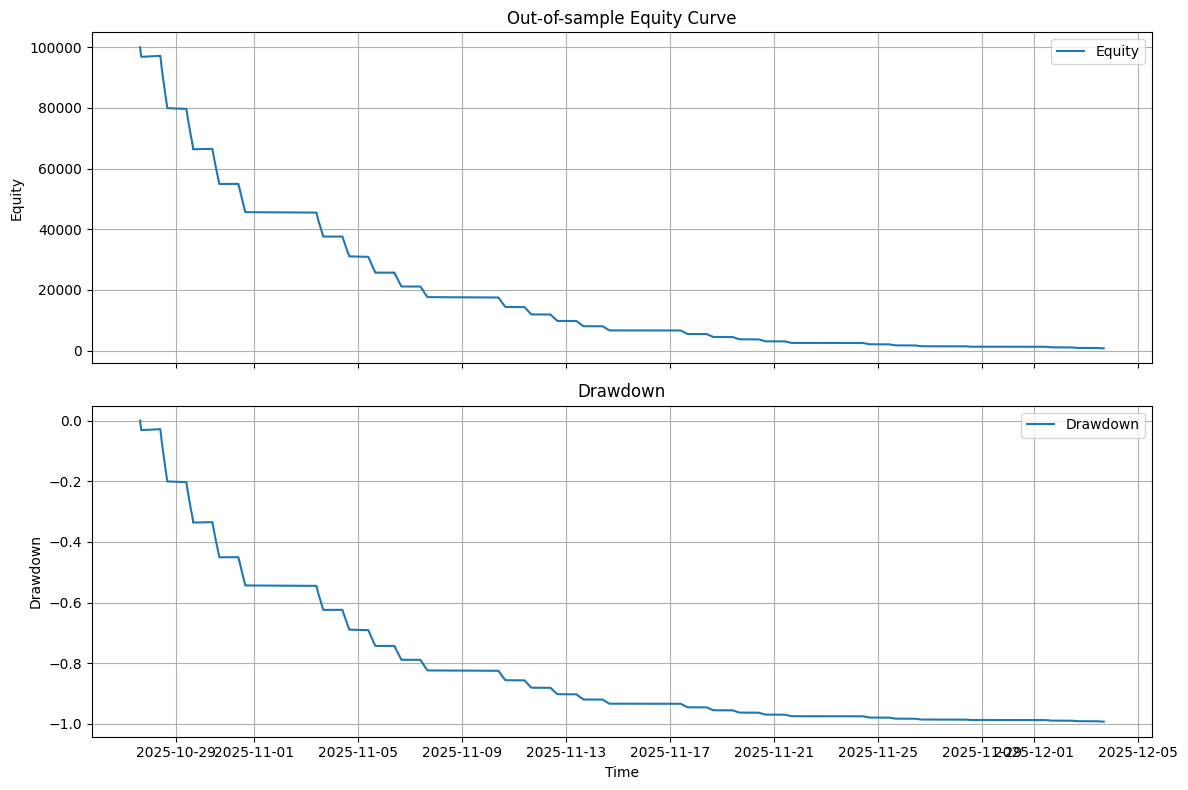


Saved account value to ppo_oos_account_value.csv
Saved stats to ppo_oos_stats.csv


In [27]:
# ============================================================
# 4. Example usage with REAL team data (train/test + backtest)
# ============================================================

if __name__ == "__main__":
    # Tickers must match the ones used in data.csv / signal CSVs.
    TICKERS = ("VOO", "IEMG", "GLDM", "TLT", "HYG")

    # IMPORTANT: adjust these paths relative to where you run the script.
    # If your working directory is RL_model/, then "../data.csv" etc. is correct
    # and the OHLC factors are under "OHLC/factor_outputs".
    prices, features, idx, feat_names = build_price_and_features(
        data_path="../data.csv",
        vol_path="../volatility_forecasts.csv",
        a6_path="../A6.csv",
        a101_path="../A101.csv",
        factor_dir="../OHLC/factor_outputs",   # <- if you run from RL_model/
        tickers=TICKERS,
    )

    print("Final aligned data shapes:")
    print("  prices:", prices.shape)      # (T, 5)
    print("  features:", features.shape)  # (T, F)
    print("  first timestamp:", idx[0])
    print("  last timestamp:", idx[-1])

    print("Any NaN in prices?", np.isnan(prices).any())
    print("Any NaN in features?", np.isnan(features).any())
    print("Any Inf in prices?", np.isinf(prices).any())
    print("Any Inf in features?", np.isinf(features).any())


    # 2. Train / test split (time-based)
    T_total = prices.shape[0]
    split_idx = int(T_total * 0.7)

    prices_train = prices[:split_idx]
    features_train = features[:split_idx]
    idx_train = idx[:split_idx]

    prices_test = prices[split_idx:]
    features_test = features[split_idx:]
    idx_test = idx[split_idx:]

    print("\nTrain / test split:")
    print("  train length:", len(idx_train), "from", idx_train[0], "to", idx_train[-1])
    print("  test length :", len(idx_test),  "from", idx_test[0],  "to", idx_test[-1])

    # 3. Build training and test environments
    env_train = MultiAssetTradingEnv(
        prices=prices_train,
        features=features_train,
        initial_cash=100000.0,
        transaction_cost=0.0005,
    )

    env_test = MultiAssetTradingEnv(
        prices=prices_test,
        features=features_test,
        initial_cash=100000.0,
        transaction_cost=0.0005,
    )

    # 4. Initialize PPO agent (train on env_train only)
    ppo_agent = PPOAgent(
        obs_dim=env_train.obs_dim,
        action_dim=env_train.n_assets,
        lr=3e-4,
        gamma=0.99,
        lam=0.95,
        clip_ratio=0.2,
    )

    # 5. In-sample training on the training window ONLY
    train_ppo_on_env(env_train, ppo_agent, total_steps=50_000, rollout_horizon=512)

    # 6. Out-of-sample backtest on the test window (frozen policy)
    df_account_value, stats = backtest_on_env(
        env_test,
        ppo_agent,
        idx_test,
        freq_per_year=252 * 390,        # roughly 1-minute bars for US equities
        plot=True,
        save_prefix="ppo_oos",
    )
